In [27]:
import ccxt
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
creds = json.loads(open('../creds.json', 'r').read())

In [279]:
exchange = ccxt.binance(creds['binance'])

In [280]:
exchange.rateLimit

500

In [281]:
exchange.enableRateLimit = True

## We fetch the last BTC tickers from Binance

In [282]:
candles = np.array(exchange.fetch_ohlcv("BTC/USDT", '1h'))
n = candles.shape[0]

In [259]:
for _ in range(4):
    candles2 = np.array(exchange.fetch_ohlcv("BTC/USDT", '1h', int(candles[0, 0] - n * 60 * 60 * 1000)))
    candles = np.vstack([candles2, candles])

In [283]:
data = pd.DataFrame()
data['timestamp'] = candles[:, 0]
data['date'] = pd.to_datetime(data['timestamp'] * 1000000)
data['open'] = candles[:, 1]
data['high'] = candles[:, 2]
data['low'] = candles[:, 3]
data['close'] = candles[:, 4]
data['volume'] = candles[:, 5]

## MACD calculation

In [284]:
ewm12 = data['close'].ewm(span=12, adjust=False).mean()
ewm26 = data['close'].ewm(span=26, adjust=False).mean()
macd = ewm12 - ewm26
macd9 = macd.ewm(span=9, adjust=False).mean()
data['macd'] = macd
data['macd9'] = macd9

In [285]:
data

,timestamp,date,open,high,low,close,volume,macd,macd9
0,1.613416e+12,2021-02-15 19:00:00,48361.00,48742.52,48354.78,48657.31,1945.428372,0.000000,0.000000
1,1.613419e+12,2021-02-15 20:00:00,48657.31,48801.00,48453.87,48580.99,3063.153399,-6.088205,-1.217641
2,1.613423e+12,2021-02-15 21:00:00,48581.00,48750.00,48111.11,48207.54,2767.082753,-40.579668,-9.090046
3,1.613426e+12,2021-02-15 22:00:00,48201.18,48334.23,47643.00,48284.89,2835.289841,-60.970078,-19.466053
4,1.613430e+12,2021-02-15 23:00:00,48284.90,48432.73,47809.99,47911.10,2105.263870,-106.068660,-36.786574
...,...,...,...,...,...,...,...,...,...
495,1.615201e+12,2021-03-08 11:00:00,50061.01,50560.00,49878.00,50496.82,2218.683534,49.871646,172.135812
496,1.615205e+12,2021-03-08 12:00:00,50490.39,50550.00,50100.01,50275.00,2463.591280,42.835795,146.275809
497,1.615208e+12,2021-03-08 13:00:00,50274.58,51065.63,50265.16,50978.43,3657.938767,92.949294,135.610506
498,1.615212e+12,2021-03-08 14:00:00,50978.42,51233.00,50122.45,50740.90,3500.519254,112.204493,130.929303


## MACD crossovers calculations

In [286]:
macd9_shifted = data['macd9'].shift(1)
macd_shifted = data['macd'].shift(1)

crossovers_buy = (macd_shifted < macd9_shifted) & (data['macd'] >= data['macd9'])
data['crossover_buy'] = crossovers_buy

crossovers_sell = (macd_shifted > macd9_shifted) & (data['macd'] <= data['macd9'])
data['crossover_sell'] = crossovers_sell

## Plotting everything

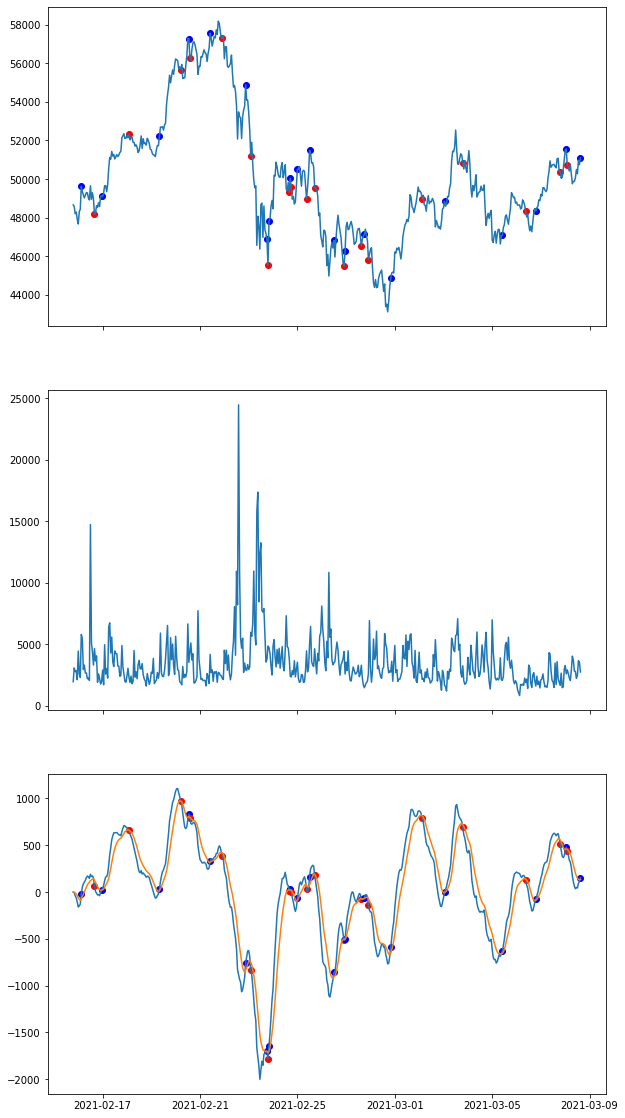

In [287]:
import matplotlib.dates as mdates
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 20))
ax1.plot(data['date'], data['close'])
ax2.plot(data['date'], data['volume'])
ax3.plot(data['date'], data['macd'])
ax3.plot(data['date'], data['macd9'])
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

for index, row in data.iterrows():
    if (row['crossover_buy']):
        ax3.scatter(row['date'], row['macd'], color='b')
        ax1.scatter(row['date'], row['close'], color='b')
    if (row['crossover_sell']):
        ax3.scatter(row['date'], row['macd'], color='r')
        ax1.scatter(row['date'], row['close'], color='r')

plt.show()

## Calculating estimated profit

In [289]:
profits = []

last_buy = None
for index, row in data.iterrows():
    if (row['crossover_buy'] and not last_buy):
        last_buy = (row['open'] + row['close']) / 2
        print("Buy @{:.2f}".format(last_buy))
    if (row['crossover_sell'] and last_buy):
        price = (row['open'] + row['close']) / 2
        variation = (price - last_buy) / last_buy * 100
        profits.append(variation - 0.065)
        last_buy = None
        print("Sell @{:.2f}, profit {:.2f}".format(price, profits[-1]))
print("Total: {:.2f}".format(np.array(profits).sum()))

Buy @49033.04
Sell @48562.29, profit -1.03
Buy @49123.68
Sell @52225.68, profit 6.25
Buy @51981.70
Sell @55745.31, profit 7.18
Buy @57283.13
Sell @56777.59, profit -0.95
Buy @57177.90
Sell @57310.99, profit 0.17
Buy @54331.27
Sell @51882.61, profit -4.57
Buy @47022.61
Sell @46197.88, profit -1.82
Buy @46668.76
Sell @49563.88, profit 6.14
Buy @49675.04
Sell @49808.01, profit 0.20
Buy @50091.73
Sell @49338.52, profit -1.57
Buy @50893.03
Sell @50091.90, profit -1.64
Buy @46625.52
Sell @45578.15, profit -2.31
Buy @45876.59
Sell @46803.43, profit 1.96
Buy @47088.71
Sell @46326.87, profit -1.68
Buy @44631.63
Sell @49123.74, profit 10.00
Buy @48681.71
Sell @51045.14, profit 4.79
Buy @47072.24
Sell @48488.38, profit 2.94
Buy @48407.15
Sell @50396.99, profit 4.05
Buy @51524.40
Sell @51144.26, profit -0.80
Buy @50922.13
Total: 27.30


In [291]:
len(profits) / (data.shape[0] / 24)

0.912